# Inference Model SAM

In [1]:
%cd sam2

/home/nuvenpreto01/Downloads/train/sam2


In [2]:
import torch
torch.cuda.empty_cache()

import torch

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


In [3]:
print(torch.cuda.memory_summary())


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [4]:
import torch
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import supervision as sv
import os
import random
from PIL import Image
import numpy as np

# use bfloat16 for the entire notebook
# from Meta notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

checkpoint = "sam2_logs/configs/train.yaml/checkpoints/checkpoint.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"
sam2 = build_sam2(model_cfg, checkpoint, device="cuda")
mask_generator = SAM2AutomaticMaskGenerator(sam2)

#checkpoint_base = "checkpoints/sam2.1_hiera_base_plus.pt"
#model_cfg_base = "configs/sam2.1/sam2.1_hiera_b+.yaml"
#sam2_base = build_sam2(model_cfg_base, checkpoint_base, device="cuda")
#mask_generator_base = SAM2AutomaticMaskGenerator(sam2_base)

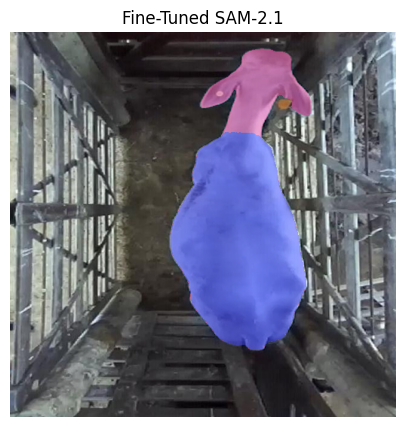

In [10]:
validation_set = os.listdir("../data/valid")

# choose random with .json extension
image = random.choice([img for img in validation_set if img.endswith(".jpg")])
image = os.path.join("../data/valid", image)
target_size = (512, 512)
opened_image = np.array(Image.open(image).convert("RGB").resize(target_size))
result = mask_generator.generate(opened_image)

detections = sv.Detections.from_sam(sam_result=result)

mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
annotated_image = opened_image.copy()
annotated_image = mask_annotator.annotate(annotated_image, detections=detections)

base_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)


import matplotlib.pyplot as plt

# Plota a imagem diretamente
plt.figure(figsize=(10, 5))
plt.title("Fine-Tuned SAM-2.1")
plt.imshow(annotated_image)
plt.axis("off")  # Não exibe os eixos
plt.show()


In [12]:
result

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]], shape=(512, 512)),
  'area': 45961,
  'bbox': [213.0, 22.0, 185.0, 400.0],
  'predicted_iou': 0.984375,
  'point_coords': [[328.0, 24.0]],
  'stability_score': 0.9662727117538452,
  'crop_box': [0.0, 0.0, 512.0, 512.0]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]], shape=(512, 512)),
  

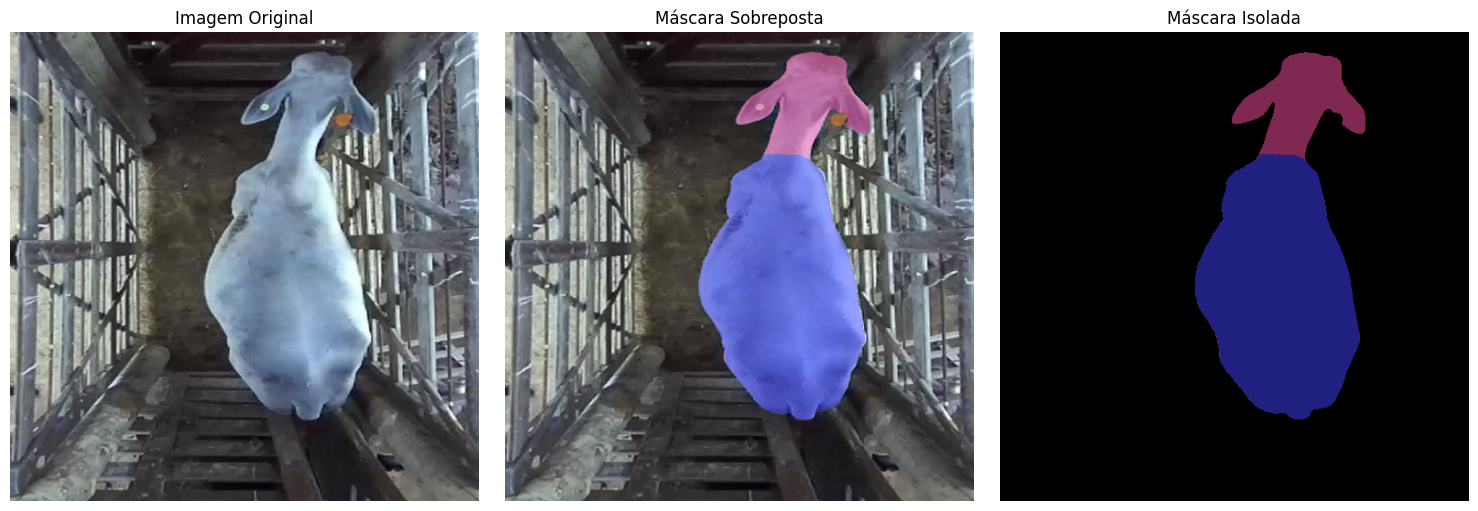

In [11]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import supervision as sv

# Criar máscara isolada (fundo preto)
isolated_mask = np.zeros_like(opened_image)
isolated_mask = mask_annotator.annotate(isolated_mask, detections=detections)

# Exibir resultados
plt.figure(figsize=(15, 5))

# Subplot 1: Imagem Original
plt.subplot(1, 3, 1)
plt.title("Imagem Original")
plt.imshow(opened_image)
plt.axis("off")

# Subplot 2: Máscara Sobreposta
plt.subplot(1, 3, 2)
plt.title("Máscara Sobreposta")
plt.imshow(annotated_image)
plt.axis("off")

# Subplot 3: Máscara Isolada
plt.subplot(1, 3, 3)
plt.title("Máscara Isolada")
plt.imshow(isolated_mask)
plt.axis("off")

plt.tight_layout()
plt.show()


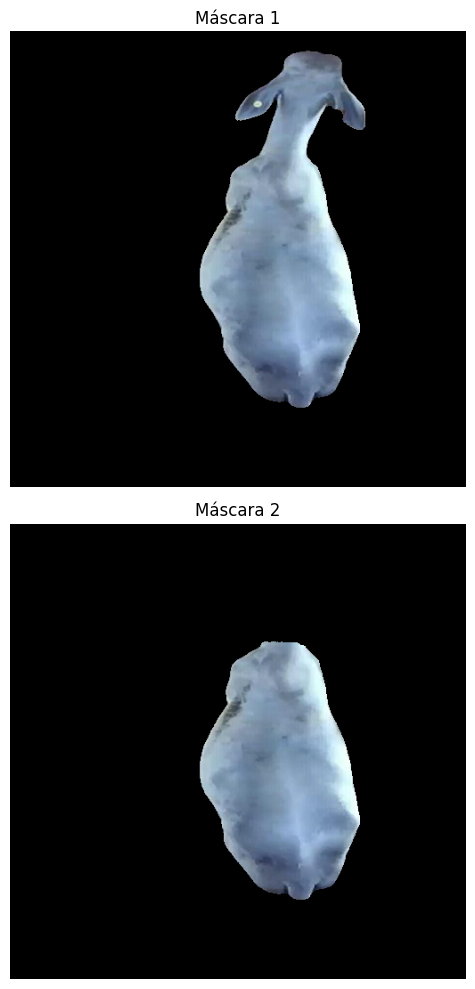

In [13]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt



# Gera as máscaras usando o SAM
result = mask_generator.generate(opened_image)

# Prepara as máscaras isoladas
masks = [item['segmentation'] for item in result]  # Lista de máscaras

# Mostra as máscaras separadas
num_masks = len(masks)
plt.figure(figsize=(10, 5 * num_masks))

for i, mask in enumerate(masks):
    isolated_mask = np.zeros_like(opened_image)
    isolated_mask[mask] = opened_image[mask]  # Aplica a máscara na imagem original

    plt.subplot(num_masks, 1, i + 1)
    plt.title(f"Máscara {i + 1}")
    plt.imshow(isolated_mask)
    plt.axis("off")

plt.tight_layout()
plt.show()


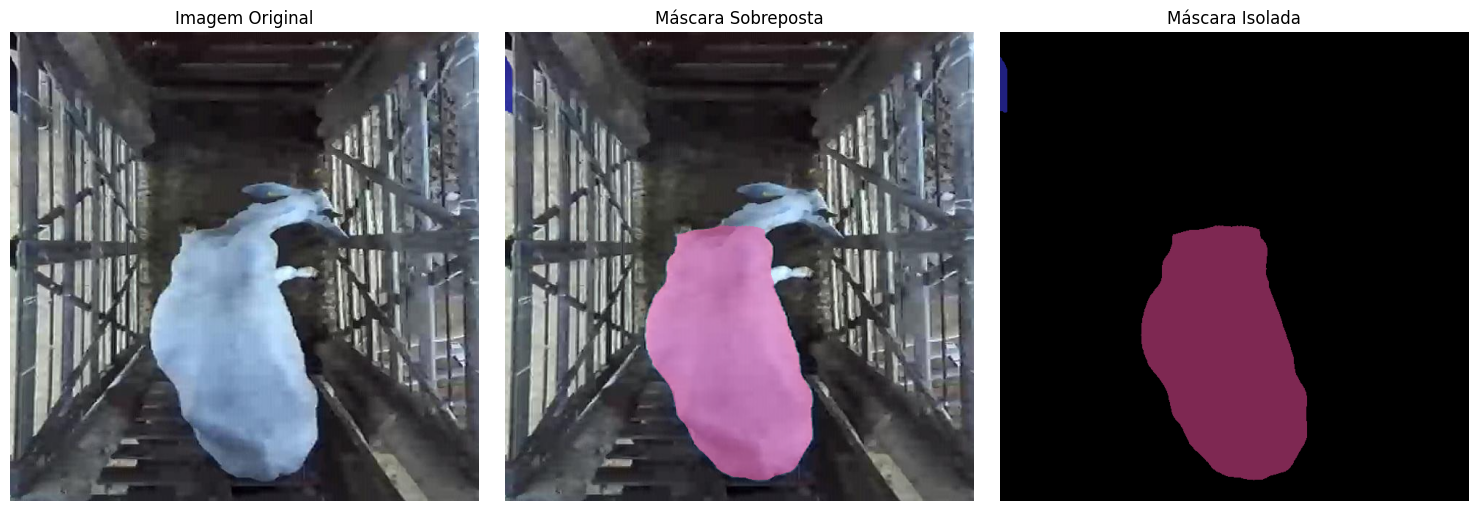

In [7]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import supervision as sv

# Carregar conjunto de validação
validation_set = os.listdir("../data/valid")

# Escolher aleatoriamente uma imagem com extensão .jpg
image = random.choice([img for img in validation_set if img.endswith(".jpg")])
image_path = os.path.join("../data/valid", image)
opened_image = np.array(Image.open(image_path).convert("RGB"))

# Gerar máscara
result = mask_generator.generate(opened_image)
detections = sv.Detections.from_sam(sam_result=result)

# Criar máscara anotada
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
annotated_image = mask_annotator.annotate(opened_image.copy(), detections=detections)

# Criar máscara isolada (fundo preto)
isolated_mask = np.zeros_like(opened_image)
isolated_mask = mask_annotator.annotate(isolated_mask, detections=detections)

# Exibir resultados
plt.figure(figsize=(15, 5))

# Subplot 1: Imagem Original
plt.subplot(1, 3, 1)
plt.title("Imagem Original")
plt.imshow(opened_image)
plt.axis("off")

# Subplot 2: Máscara Sobreposta
plt.subplot(1, 3, 2)
plt.title("Máscara Sobreposta")
plt.imshow(annotated_image)
plt.axis("off")

# Subplot 3: Máscara Isolada
plt.subplot(1, 3, 3)
plt.title("Máscara Isolada")
plt.imshow(isolated_mask)
plt.axis("off")

plt.tight_layout()
plt.show()


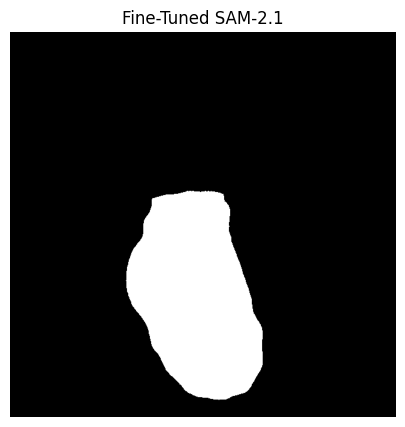

In [9]:
if isinstance(detections, tuple):
    fig, axs = plt.subplots(1, len(detections), figsize=(15, 5))
    for i, detection in enumerate(detections):
        # Verifica se é uma máscara válida
        if detection.mask is not None:
            mask_image = detection.mask
            axs[i].imshow(mask_image[0], cmap='gray')  # Exibe a primeira máscara da lista
        axs[i].axis("off")
        axs[i].set_title(f"Mask {i+1}")
else:
    # Se apenas uma máscara for gerada
    if detections.mask is not None:
        mask_image = detections.mask
        plt.figure(figsize=(10, 5))
        plt.title("Fine-Tuned SAM-2.1")
        plt.imshow(mask_image[0], cmap='gray')  # Exibe a primeira máscara da lista
        plt.axis("off")  # Não exibe os eixos
        plt.show()
